Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Nelia Korotushak"
COLLABORATORS = ""

---

# Task: A Bayes Classifier Based on Density Estimation

Implement and evaluate a classifier for [expression data](https://dl1.cuni.cz/pluginfile.php/301688/course/section/59162/burkholderia_pseudomallei)
of patients infected and noninfected by
[Burkholderia Pseudomallei](https://en.wikipedia.org/wiki/Burkholderia_pseudomallei).
You should implement a variant of the Bayes classifier, which works in the following way.
The classifier is trained on a training set, which will be split into infected and noninfected
patients. We will construct a density estimator for each of these two groups and then
use it to classify new inputs similarly to the Bayes classifier.

We will implement the classifier to be compatible with classifiers from the scikit-learn library.

More details on the classifier:

1. It splits the train set into positive and negative train sets. For each set,
   the classier fits a kernel density estimator
   (class `sklearn.neighbors.KernelDensity()`). This allows
   for a new input $x$ and a label $y \in \{\mathit{positive}, \mathit{negative}\}$
   to compute density function $f_y(x)$ for the probability $P(x\mid y)$. That is, we
   obtain a generative model for each target class.

    **Remark:** Method `score_samples()` of the class `sklearn.neighbors.KernelDensity()` returns **log-density**, not the density!

2. For each target class $y$, the classifier estimates the prior probability
   $P(y)$ using the size of the respective training set.
3. For a new input $x$, the posterior probability for each class is
   $$P(y \mid x) = \frac{P(y) \cdot  P(x \mid y)}{P(x)} \propto \frac{P(y) \cdot f_y(x)}{P(x)}.$$
   The class that maximizes this posterior is the label assigned to the point. Hence,
   the classification of $x$ is
   $$\mathrm{argmax}_{y\in\{\mathit{positive}, \mathit{negative}\}} P(y)\cdot f_y(x).$$
   Of course, $P(y\mid x)$ need not be equal to $P(y)\cdot P(x\mid y)$, but similarly as
   for the Naïve Bayes classifier, we omit a denominator that is the same for both target classes.

   Additionally, the resulting probabilities can be very low. Transforming log-probability
   into probability can cause a loss of accuracy (e.g., `numpy.exp(-745)` returns `0.0`).
   In order not to lose accuracy, you should use the logarithm of the priors and the logarithm
   of the densities:
        $$\mathrm{argmax}_{y\in\{\mathit{positive}, \mathit{negative}\}} \log (P(y)\cdot f_y(x)).$$

**Tasks:**

1. Implement the classifier class `KDEBayes` that can employ different kernel density estimators
   with different kernels and various bandwidths.
2. Split the data on melioidosis patients into train and test sets, fit
   a `KDEBayes` classifier to the training data, and evaluate the accuracy
   of the constructed classifier on the test set. Print the classification report
   (`classification_record()`) and plot the confusion matrix (function `plot_confusion_matrix`).
3. Find the best combination of bandwidth and kernel type.
4. Add a preprocessing step that normalizes data using various normalizers. Find the best
   combination of preprocessing, kernel, and bandwidth.
5. Visualize your best clssifier.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## 1. Classifier implementation

We will implement the classifier `KDEBayes` similar to other classifiers in `scikit-learn`.

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted


class KDEBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        """Constructor:
        kwargs are keyword arguments that will be passed to both KernelDensity estimators 
        for positive and negative training samples. Both estimators will be trained 
        with the same parameters.
        """
        self.pos_KDE = KernelDensity(**kwargs)
        self.neg_KDE = KernelDensity(**kwargs)

    def fit(self, X, y):
        """
        Fit the estimator to the training data.
           X is a two-dimensional numpy array with observations,
           y is a binary vector with labels; 0 means negative, and 1 means positive class.
        Splits the dataset into positive and negative samples,
        fits the self.pos_KDE kernel density estimator to the positive set 
        and the self.neg_KDE kernel density estimator to the negative set.
        Further, it sets self.pos_prior to the prior probability of the positive class
        (i.e., the ratio of positive samples in the training data) and
        self.neg_prior to the prior probability of the negative class.
        """
        # Custom attribute to track if the estimator is already fitted
        self._is_fitted = True
        # 
        # YOUR CODE HERE
        positive = X[y == 1]
        negative = X[y == 0]
        self.pos_KDE.fit(positive)
        self.neg_KDE.fit(negative)
        self.pos_prior = np.log(len(positive) / len(X))
        self.neg_prior = np.log(len(negative) / len(X))
        return self

    def predict(self, X):
        """
        Perform predictions for samples in the two-dimensional array X.

        If the estimator is not fitted, then raise NotFittedError.
        Otherwise, predict the class for all samples in X.
        Return a binary array with 0 for negative and 1 for positive classification.

        Remark: Method score_samples() of the class sklearn.neighbors.KernelDensity() 
        returns log-density, not the density!
        """
        check_is_fitted(self)
        # Perform prediction logic
        # YOUR CODE HERE
        log_pos = self.pos_KDE.score_samples(X) + self.pos_prior # the same as np.exp(self.pos_KDE.score_samples(X)) * np.exp(self.pos_prior), but more stable
        log_neg = self.neg_KDE.score_samples(X) + self.neg_prior
        return (log_pos > log_neg).astype(int)

    def score(self, X, y):
        """
        Calculate accuracy of the prediction on the set X with true labeling y.
           X is a two-dimensional array of samples,
           y is the true labeling of the samples.

        If the estimator is not fitted, then raise NotFittedError.
        Otherwise, return the accuracy of the prediction (method predict()) with
        respect to the true labels y. Hence, it returns a number between 0 and 1.
        """
        check_is_fitted(self)
        # YOUR CODE HERE
        return np.mean(self.predict(X) == y)   # predict, compare with y (if the prediction is correct, number = 1), sum them and divide by the number of samples (mean), so we get the accuracy [0,1]

    def __sklearn_is_fitted__(self):
        """
        Check the fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

Below, we will test your implementation for the `KDEBayes` class (**2 points for your grade**).

In [42]:
# Do not change this cell as it also contains hidden tests

train_pos = np.array([[0,1], [1,0]])
train_neg = np.array([[0,0], [1,1]])
X_xor = np.vstack((train_pos, train_neg))
y_xor = np.array([1, 1, 0, 0])

clf = KDEBayes()
clf.fit(X_xor, y_xor)

assert (clf.predict(X_xor) == y_xor).all()



## 2. Prepare data, train `KDEBayes` classifier, and evaluate it

We will use test data for Burkholderia pseudomallei. 

In [43]:
bp_all = pd.read_csv('burkholderia_pseudomallei.csv', sep='\t')
bp_all.head()

,BPSS1512,BPSL2520,BPSL2522,BPSS1525,BPSS1516,BPSL2096,BPSS1722,BPSS2141,BPSL2698,BPSS0476,...,BPSS1998,BPSS2277,BPSL0606,BPSS0226,BPSS1401,BPSL0361,BPSS0796.2,BPSS1382,BPSS0412,Target
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,333.50,0.0,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0
1,10.33,162.33,132.33,50.33,64.33,0.00,135.33,682.33,0.0,13.33,...,146.33,59.33,0.0,0.0,0.00,0.0,0.0,0.0,60.33,0
2,0.00,0.00,2173.33,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0
3,0.00,534.83,474.83,0.00,0.00,336.83,0.00,673.83,0.0,0.00,...,0.00,0.00,0.0,0.0,126.83,0.0,0.0,0.0,0.00,0
4,5558.33,422.33,156.33,0.00,0.00,0.00,108.33,0.00,0.0,386.33,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0


In [44]:
bp_all['Target'].value_counts()

Target
0    87
1    59
Name: count, dtype: int64

87 patients are positive (they have the bacteria), and 59 patients are negative (they do not have the bacteria). Note that the **`Target` attribute is flipped**. In the following we will use `1-Target` as the class. We will create dataset `X` with predictors and `y` with the labels.

In [45]:
X = bp_all.drop(columns=['Target'])
y = 1 - bp_all['Target']

We will split `X` into a train and a test set with sizes 80% and 20%, respectively, using the function
`sklearn.model_selection.train_test_split()` with the random generator seed `random_state=42` 
and `stratify=y` to obtain a stratified split with the same ratio of positive samples in both train and test sets. Using the parameter `random_state=42`, we
obtain a train set with 69 positive and 47 negative patients.

In [46]:
from sklearn.model_selection import train_test_split

# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"{X_train.shape=}\n{X_test.shape=}")
print(y_train.value_counts())

X_train.shape=(116, 214)
X_test.shape=(30, 214)
Target
1    69
0    47
Name: count, dtype: int64


Create an instance of the `KDEBayes` classifier (with the default parameters) and fit it to the train set `X_train.`
Compute and print the accuracy of the classifier on the test set and plot the corresponding confusion matrix (e.g., using `confusion_matrix` and `ConfusionMatrixDisplay`). 

Accuracy: 0.8333333333333334


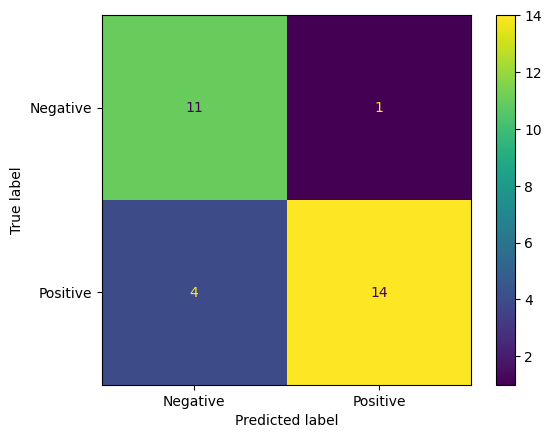

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# YOUR CODE HERE
# create classifier and train it 
classifier = KDEBayes()
classifier.fit(X_train, y_train)

# compute accuracy 
accuracy = classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# compute confusion matrix and display it 
matrix = confusion_matrix(y_test, classifier.predict(X_test))
disp = ConfusionMatrixDisplay(matrix, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()

## 3 Find the best combination of bandwidth and kernel

For plotting accuracy for different bandwidth value we will use the following function.

In [48]:
def plot_accuracy_vs_bandwidth(bandwidth_list, accuracy_list, kernel='gaussian', scaler=None):
    """
    Plot the accuracy for the (ordered) list of bandwidths.
       bandwidth_list is the list of bandwidth values,
       accuracy_list is the list of the corresponding accuracy,
       kernel is the name of a kernel (used for the title of the plot),
       scaler is the name of the scaler (used for the title) of the plot.
    """
    plt.plot(bandwidth_list, accuracy_list,'+:')
    if scaler:
        plt.title(f"Accuracy for {scaler=} and {kernel=} (maximal accuracy {max(accuracy_list)})")
    else:
        plt.title(f"Accuracy for {kernel=} (maximal accuracy {max(accuracy_list)})")
    plt.xlabel("Bandwidth")
    plt.ylabel("Accuracy")
    plt.show()

The above-constructed classifier uses the Gaussian kernel with a bandwidth of `1.0`. Find a value of bandwidth for the Gaussian kernel, which improves the accuracy of the classifier (that uses the Gaussian kernel). Plot accuracy for values of bandwidth from interval 0.01 to 100000. **Use the  values `10 ** np.arange(-2, 5.0, 0.01)`**. Your code should store the best achieved accuracy in the variable `best_acc` and the best bandwidth in the variable `best_bw`, and print the value of bandwidth for which the the classifier achieved **the best accuracy on the test set** (**0.5 points for your grade**). 

The best accuracy 0.8333333333333334 was achieved with bandwidth 0.01


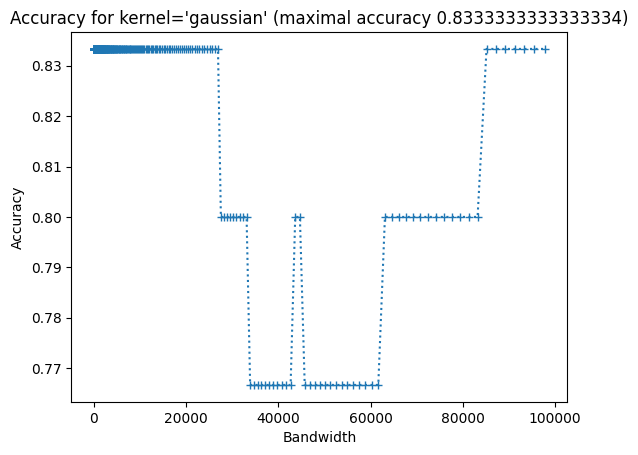

In [54]:
# try to find better bandwidth
bandwidths = 10 ** np.arange(-2, 5.0, 0.01)

# YOUR CODE HERE
band_list = 10**np.arange(-2, 5, 0.01)
scores = []

best_bw = 0
best_acc = 0
for bw in band_list:
    classifier = KDEBayes(bandwidth=bw)
    classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_test, y_test))
    if scores[-1] > best_acc:
        # update the best accuracy and bandwidth
        best_acc = scores[-1]
        best_bw = bw

print(f"The best accuracy {best_acc} was achieved with bandwidth {best_bw}")

plot_accuracy_vs_bandwidth(bandwidths, scores, kernel='gaussian')

After seeing the plot, consider extending the range for the possible bandwidth. Then, modify the bandwidth range to **improve accuracy**. Again, use `plot_accuracy_vs_bandwidth` to plot the accuracy with respect to the bandwidth (**0.5 points for your grade**).

The best accuracy 0.8333333333333334 was achieved with bandwidth 0.001


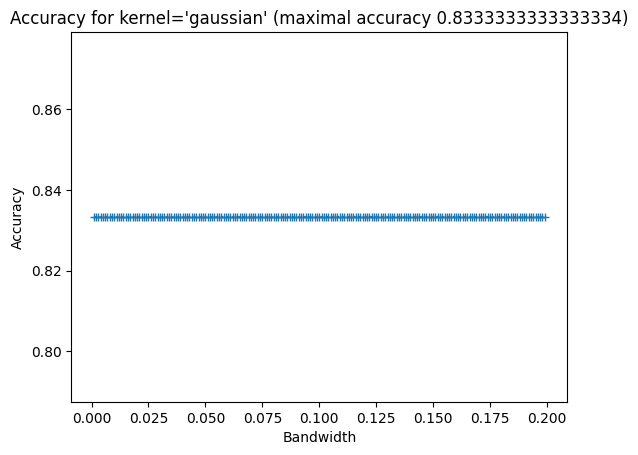

In [55]:
# YOUR CODE HERE
# the best bandwidth is 0.01, I will try to find a better one near it 
bandwidths = np.arange(0.001, 0.2, 0.001)
scores = []

best_bw = 0
best_acc = 0
for bw in bandwidths:
    classifier = KDEBayes(bandwidth=bw)
    classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_test, y_test))
    if scores[-1] > best_acc:
        # update the best accuracy and bandwidth
        best_acc = scores[-1]
        best_bw = bw

print(f"The best accuracy {best_acc} was achieved with bandwidth {best_bw}")

plot_accuracy_vs_bandwidth(bandwidths, scores, 'gaussian')

Your obtained results (`best_acc`) will be tested (using some hidden test) in the following cell.

In [37]:
# do not modify this cell

assert 0 < best_acc <= 1.0


In `KernelDensity`, we can use several different kernels. Implement the following function, which computes a table (pandas `DataFrame`) with rows containing the name of a kernel, the best bandwidth, and the best accuracy achieved for the kernel. Simultaneously, for each kernel, the function plots the accuracy for each bandwidth using the function `plot_accuracy_vs_bandwidth`.

In [103]:
def plot_accuracy_vs_band_one_subplot(bandwidth_list, accuracy_list, kernels, num_plots = 1, scaler = None):
    # 3 plots in one row
    num_rows = num_plots//3 + int(num_plots % 3 > 0)
    # enlarge figure size
    plt.figure(figsize=(15, 5*num_rows))
    fig = plt.subplot(num_rows,3,1)
    # make distance between plots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # set the title of the figure to the scaler
    if scaler:
        plt.suptitle(f"Accuracy for {scaler=}", fontsize=16)
    plot = 1
    for accuracies in accuracy_list:
        plt.subplot(num_rows,3,plot, sharey=fig)
        # round accuracy to 3 decimal places in f{} string
        plt.title(f"Accuracy for {kernels[plot-1]} \n (maximal accuracy {max(accuracies):.3f})", fontsize=8)
        plt.plot(bandwidth_list, accuracies,'+:')
        plt.xlabel("Bandwidth")
        plt.ylabel("Accuracy")
        plot += 1
    plt.show()

def optimal_kernel_bandwidth(X_train, y_train, X_test, y_test, kernels, bandwidths):
    """
    Compute a table with the best bandwidth and the best accuracy 
    for each kernel in the list of kernels.
       X_train are the training samples,
       y_train are the labels for the samples in X_train,
       X_test are the test samples,
       y_test are the labels for the samples in X_test,
       kernels is a list of names (strings) of kernels,
       bandwidth is a list or numpy array of possible bandwidth values.
       
    For each kernel, the function plots the dependence between the bandwidth and accuracy 
    It returns a table with columns 'Kernel', 'Bandwidth', and 'Accuracy', where
    for each kernel from kernels, there is a row with the best bandwidth
    and the best accuracy achieved by a KDEBayes on X_test with true labels y_test 
    that was trained on the train set X_train with true labels y_train.
    """
    # YOUR CODE HERE
    result = [] 
    accuracies = []
    for kernel in kernels:
      best_bw = 0
      best_acc = 0
      accs = []
      for bw in bandwidths:
         classifier = KDEBayes(kernel=kernel, bandwidth=bw)
         classifier.fit(X_train, y_train)
         acc = classifier.score(X_test, y_test)
         accs.append(acc)
         if acc > best_acc:
            best_acc = acc
            best_bw = bw
      accuracies.append(accs)
      result.append([kernel, best_bw, best_acc])
    plot_accuracy_vs_band_one_subplot(bandwidths, accuracies, kernels=kernels, num_plots=len(kernels))
    return pd.DataFrame(result, columns=['Kernel', 'Bandwidth', 'Accuracy'])


The following cell should produce a plot for each bandwidth and a `pandas` table **similar** the following one

![table](Table.png)

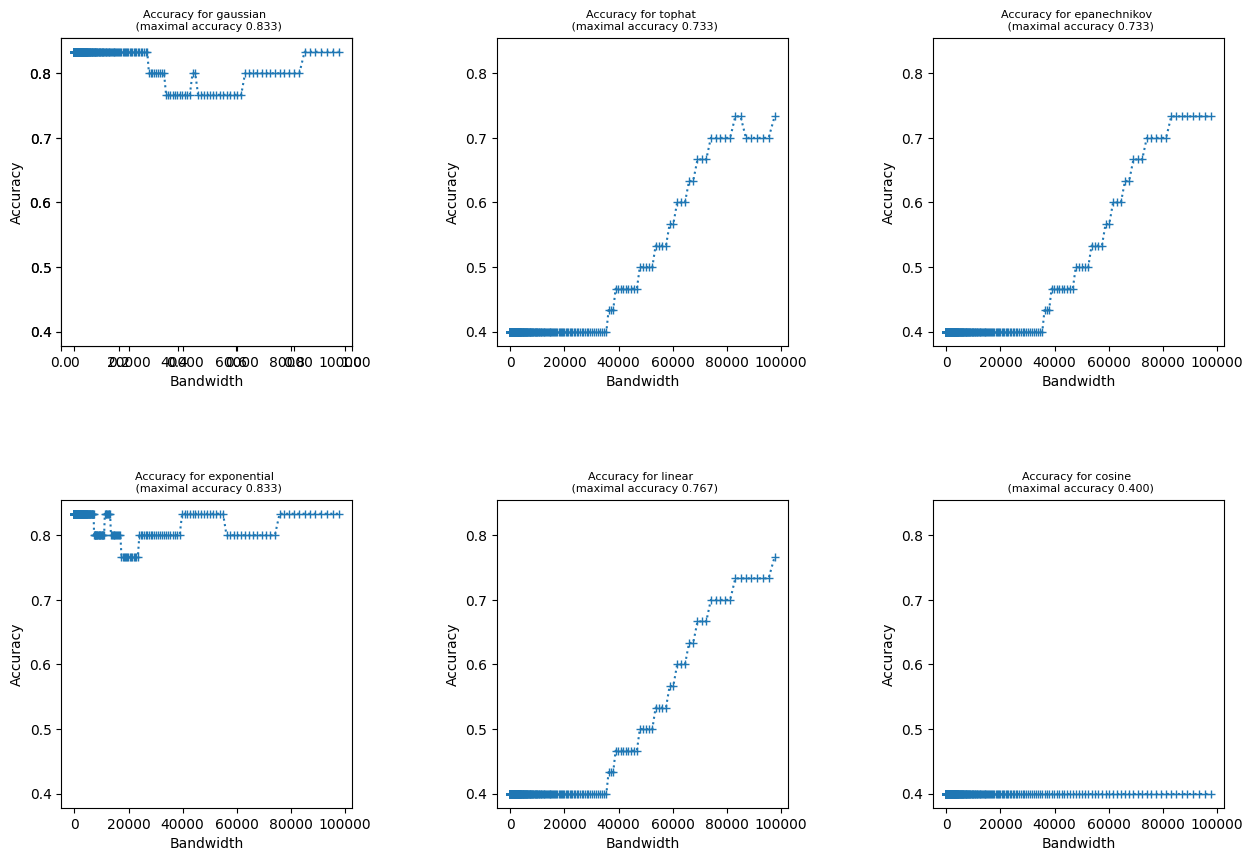

,Kernel,Bandwidth,Accuracy
0,gaussian,0.010000,0.833333
1,tophat,83176.377110,0.733333
2,epanechnikov,83176.377110,0.733333
3,exponential,0.010000,0.833333
4,linear,97723.722096,0.766667
5,cosine,0.010000,0.400000


In [104]:
table = optimal_kernel_bandwidth(X_train, y_train, X_test, y_test, 
                                 ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'],
                                 10 ** np.arange(-2, 5.0, 0.01)
                                )
table

Again, inspect the plots and consider modifying the range for the possible bandwidth. Then, in the cell below, modify the range to improve accuracy or confirm that no wider range is needed.

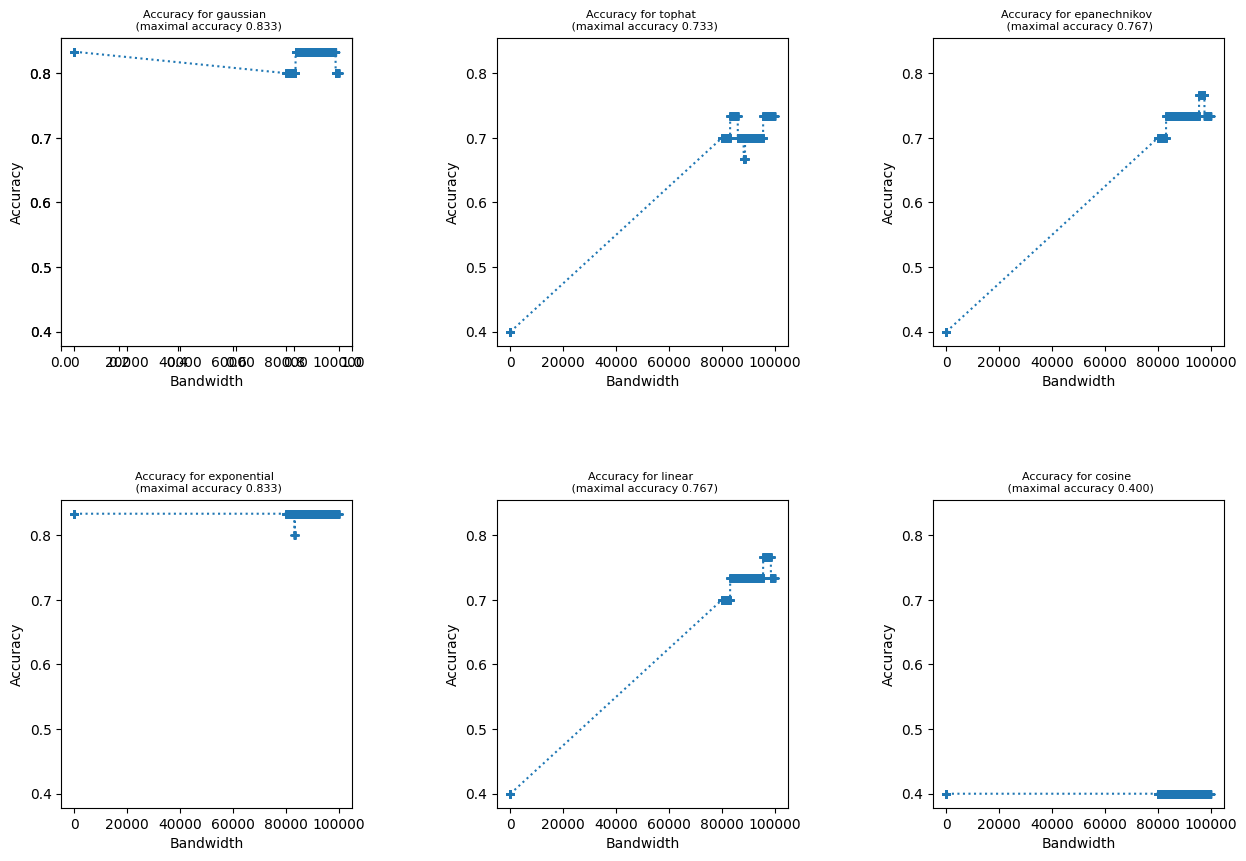

,Kernel,Bandwidth,Accuracy
0,gaussian,0.001,0.833333
1,tophat,83130.000,0.733333
2,epanechnikov,95620.000,0.766667
3,exponential,0.001,0.833333
4,linear,95620.000,0.766667
5,cosine,0.001,0.400000


In [105]:
bandwidths = np.concatenate([np.arange(0.001, 0.2, 0.001), np.arange(80000, 100000, 10)]) # wider range near the best bandwidth (very low + very high values)
# YOUR CODE HERE

table = optimal_kernel_bandwidth(X_train, y_train, X_test, y_test, 
                                 ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'],
                                 bandwidths
                                )
table

# even better value for epanechnikov is found 

In a previous lab, we saw that the distribution of values for many features is skewed. Here, we will transform each feature $x_i$ into $\log(x + 0.1)$, where $\log$ is the natural logarithm function.  

X_train_log.shape=(116, 214)
X_test_log.shape=(30, 214)
Target
1    69
0    47
Name: count, dtype: int64


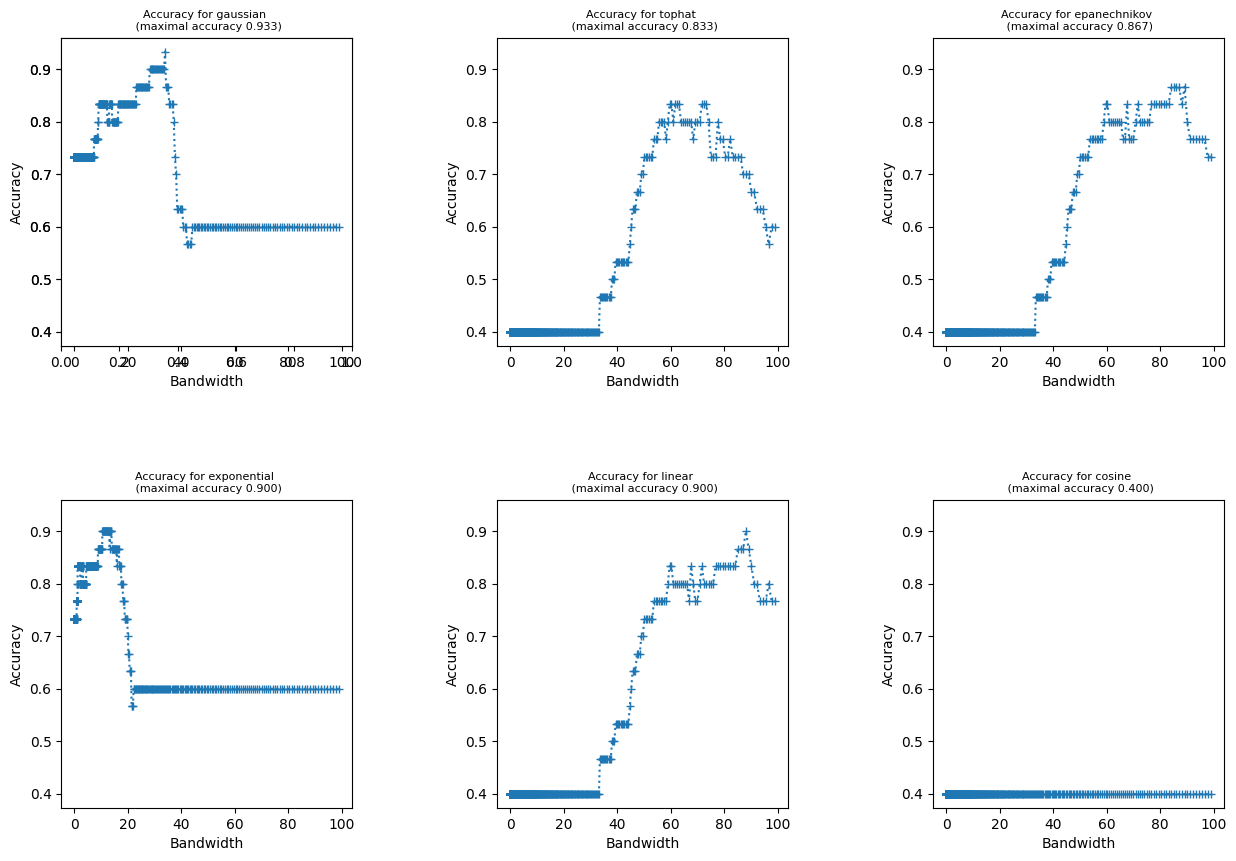

,Kernel,Bandwidth,Accuracy
0,gaussian,33.884416,0.933333
1,tophat,59.566214,0.833333
2,epanechnikov,84.139514,0.866667
3,exponential,10.471285,0.900000
4,linear,88.104887,0.900000
5,cosine,0.010000,0.400000


In [106]:
from sklearn.model_selection import train_test_split

X_train_log, X_test_log, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# YOUR CODE HERE
# natural logarithm transformation
X_train_log = np.log(X_train_log + 0.1)
X_test_log = np.log(X_test_log + 0.1)
print(f"{X_train_log.shape=}\n{X_test_log.shape=}")
print(y_train.value_counts())
bandwidths = 10 ** np.arange(-2, 2, 0.005)

table = optimal_kernel_bandwidth(X_train_log, y_train, X_test_log, y_test, 
                                 ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'],
                                 bandwidths
                                )
table

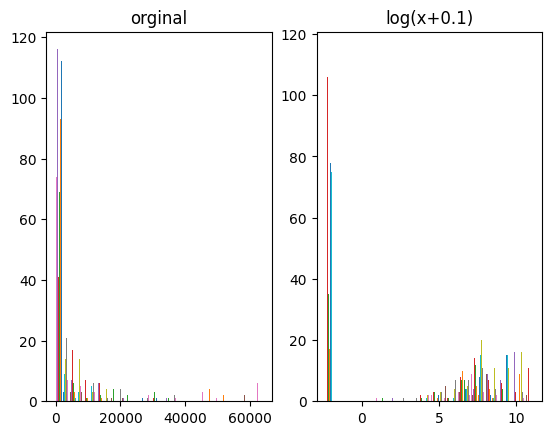

In [ ]:
fig = plt.subplot(1,2,1)
plt.title('orginal')
plt.hist(X_train, bins=30)
plt.subplot(1,2,2)
plt.title(f'log(x+0.1)')
plt.hist(X_train_log, bins=30)
plt.show()

# still looks strange, but separation into 2 groups is present now

The computed `table` will be tested below 
including some hidden tests (**1 point**).

In [60]:
best_kernel = table['Kernel'][table['Accuracy'].argmax()]
best_bandwidth = table['Bandwidth'][table['Accuracy'].argmax()]
best_accuracy = table['Accuracy'][table['Accuracy'].argmax()]
print(f"The best accuracy {best_accuracy} was achieved with kernel {best_kernel} and bandwidth {best_bandwidth}")



The best accuracy 0.9333333333333333 was achieved with kernel gaussian and bandwidth 33.884415613914385


## 4 Add preprocessing

Normalizing data before its analysis can help yield better results. We can 
combine `StandardScaler` which standardizes features by removing the mean and scaling to unit variance, with `KDEBayes.`
using `Pipeline`. The resulting classifier has the same methods as `KDEBayes.` E.g.,

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaled_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('kde', KDEBayes(kernel='gaussian', bandwidth=2.0))
])
scaled_classifier.fit(X_train, y_train)
scaled_classifier.predict(X_test)

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0])

Does the above-constructed classifier perform better (= it has higher accuracy) when we normalize the input data before constructing the density estimator? Find the best combination of a normalizer from the set `[MinMaxScaler, StandardScaler, MaxAbsScaler, Normalizer]`, a kernel from the set `['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']` and bandwidth from the array `10 ** np.arange(-2, 5.0, 0.01)`. 

In [112]:
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    MaxAbsScaler,
    Normalizer
)

def optimal_scaler_kernel_bandwidth(X_train, y_train, X_test, y_test, scalers, kernels, bandwidths):
    """
    Find the best combination of a scaler, kernel, and bandwidth. 
       scalers is a list of scalers (normalizers),
       kernels is a list of names of kernels,
       bandwidth is a list or numpy array of possible values of bandwidth.
    For each combination of scaler and kernel, the function plots accuracy for each bandwidth.
    Return table with columns 'Scaler', 'Kernel', 'Bandwidth', and 'Accuracy', where
    for each scaler from scalers, there is a row with the best kernel, bandwidth
    and the best accuracy achieved by a KDEBayes on X_test with true labels y_test 
    that was trained on the train set X_train with true labels y_train.
    """
    # YOUR CODE HERE
    result = []
    for scaler in scalers:
        best_bw = 0
        best_acc = 0
        best_kernel = ''
        accuracies = []
        for kernel in kernels:
            accs = []
            for bw in bandwidths:
                classifier = Pipeline([
                    ('scaler', scaler()),
                    ('kde', KDEBayes(kernel=kernel, bandwidth=bw))
                ])
                classifier.fit(X_train, y_train)
                acc = classifier.score(X_test, y_test)
                accs.append(acc)
                if acc > best_acc:
                    best_acc = acc
                    best_bw = bw
                    best_kernel = kernel
            accuracies.append(accs)
        plot_accuracy_vs_band_one_subplot(bandwidths, accuracies, kernels=kernels, scaler=scaler.__name__, num_plots=len(kernels))
        result.append([scaler.__name__, best_kernel, best_bw, best_acc])
    return pd.DataFrame(result, columns=['Scaler', 'Kernel', 'Bandwidth', 'Accuracy'])


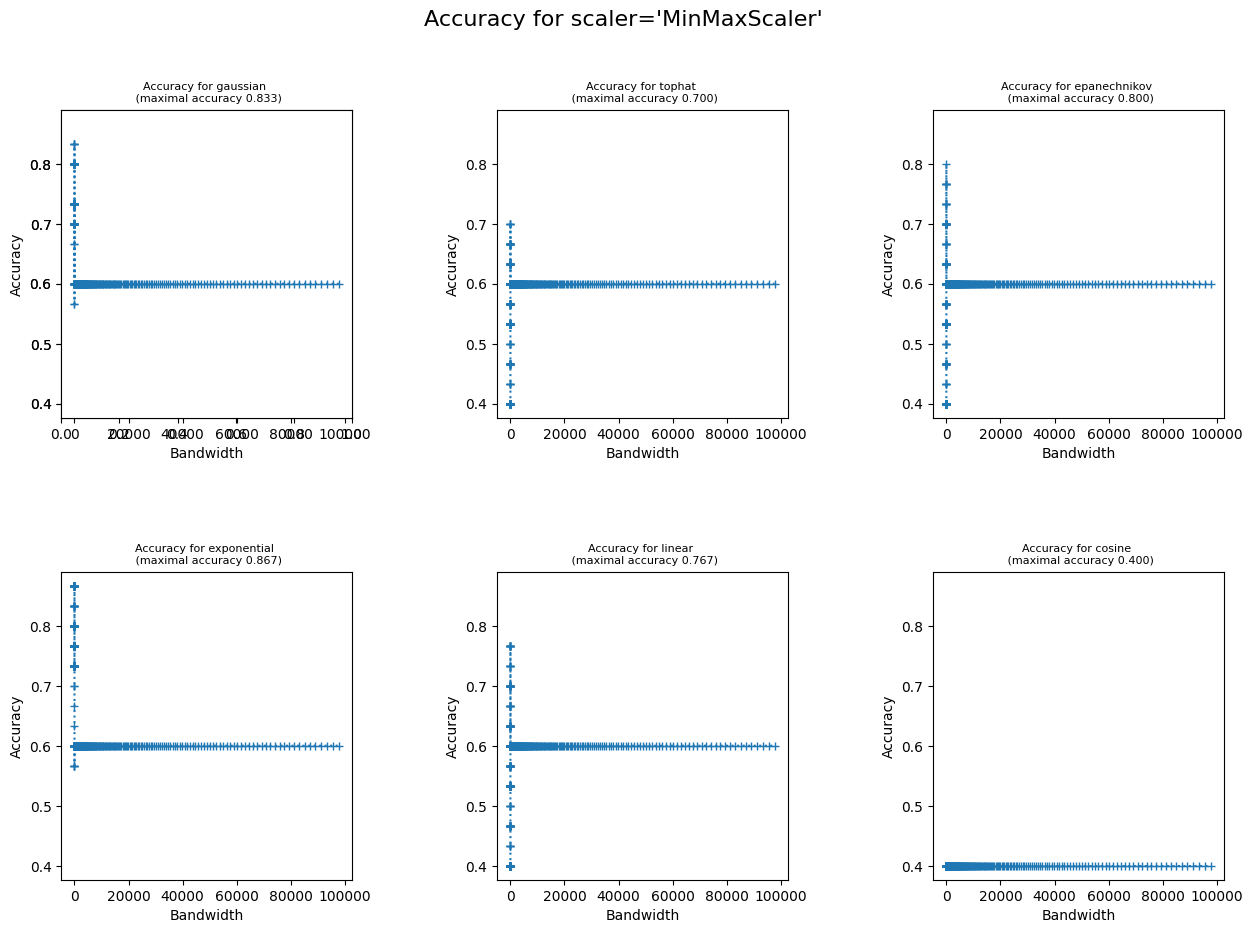

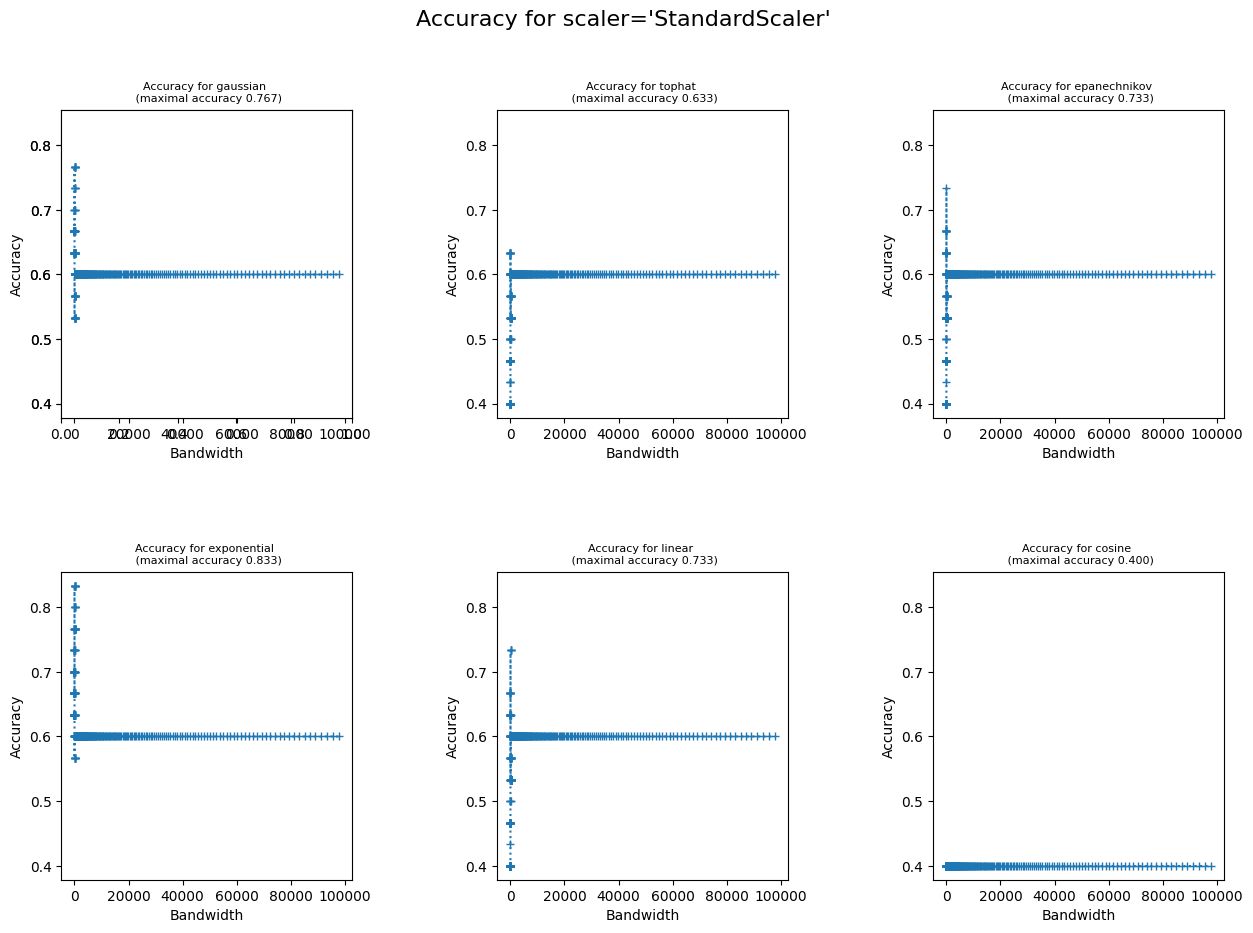

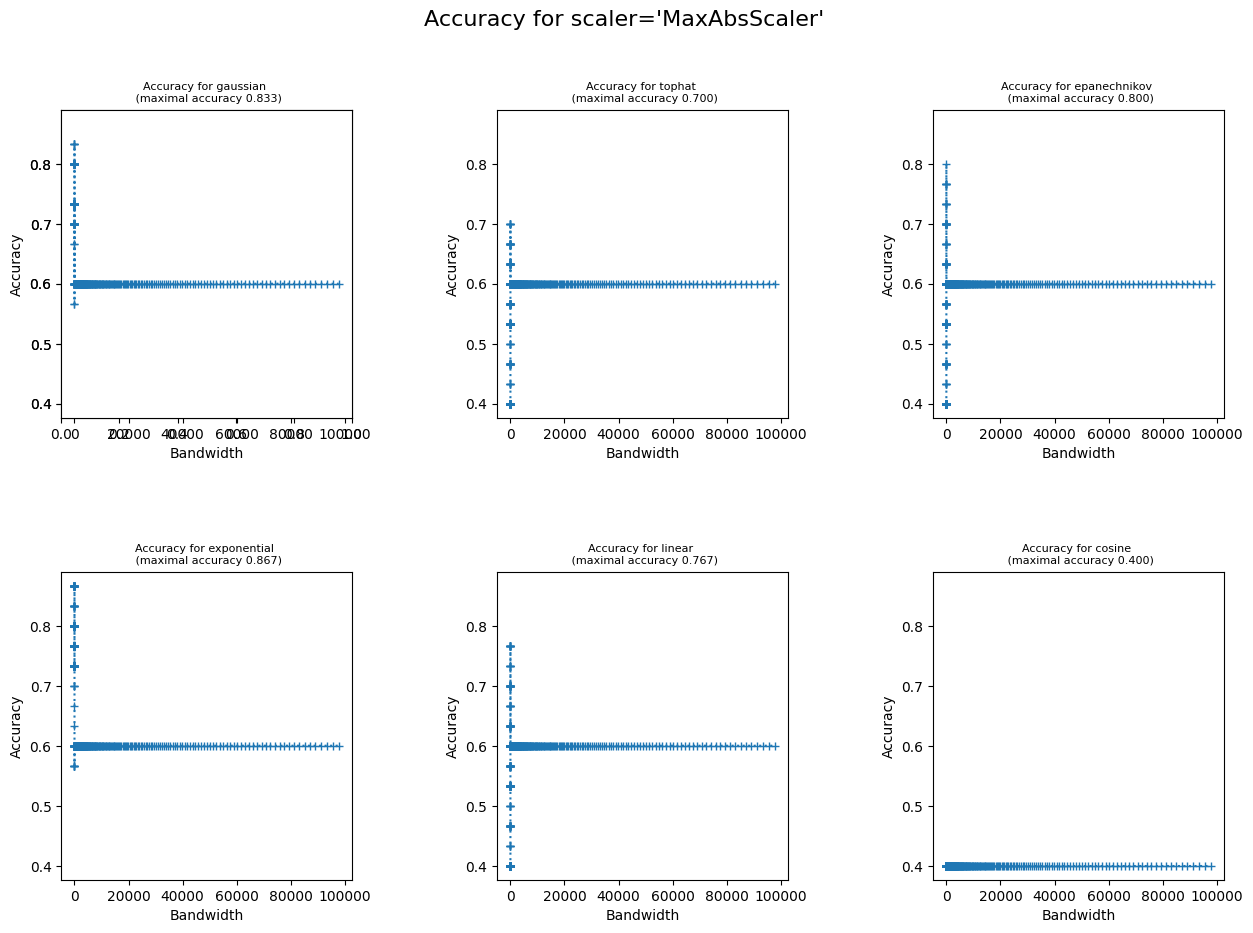

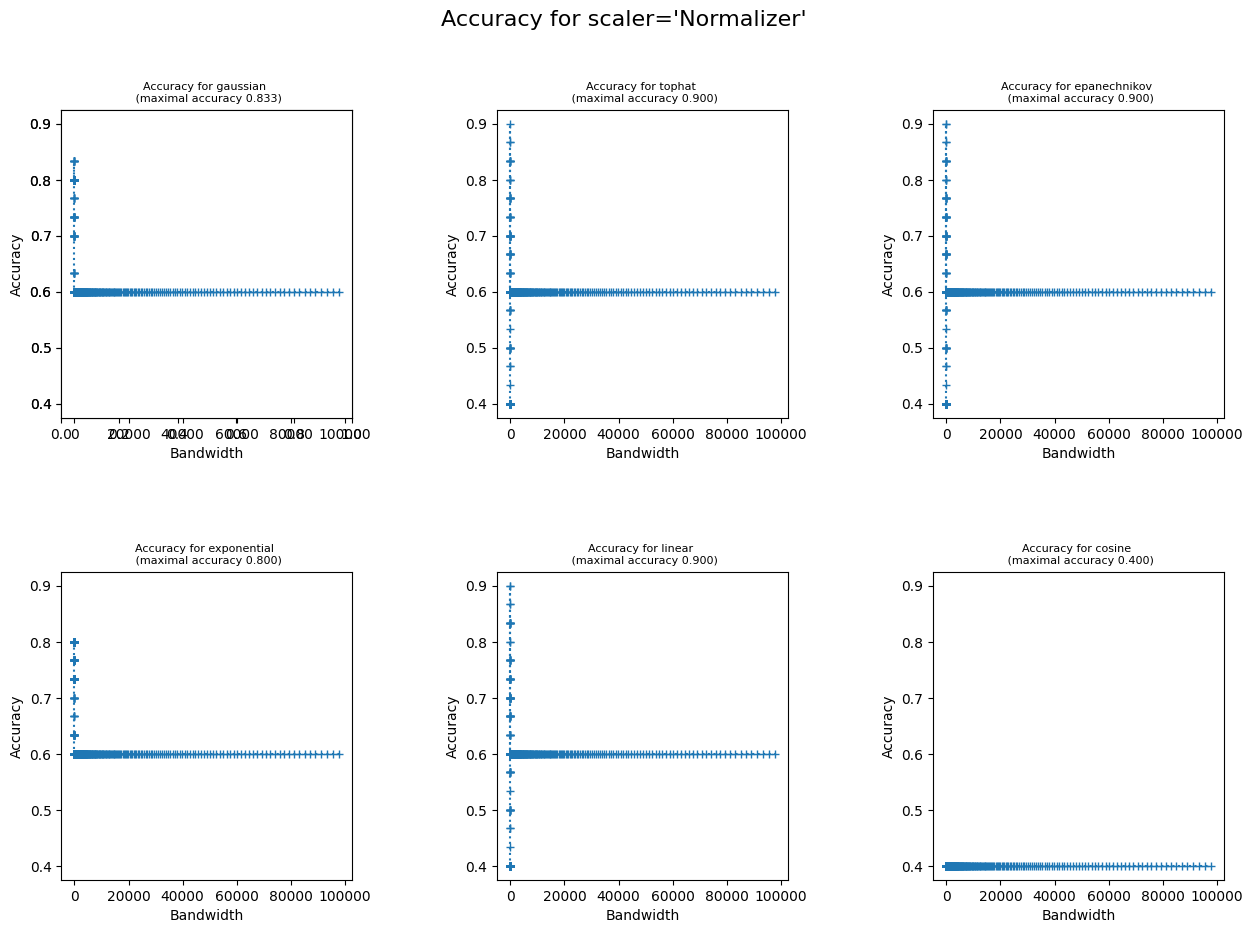

,Scaler,Kernel,Bandwidth,Accuracy
0,MinMaxScaler,exponential,0.851138,0.866667
1,StandardScaler,exponential,5.754399,0.833333
2,MaxAbsScaler,exponential,0.851138,0.866667
3,Normalizer,tophat,0.691831,0.900000


In [113]:
scalers = [MinMaxScaler, StandardScaler, MaxAbsScaler, Normalizer]
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
bandwidths = 10 ** np.arange(-2, 5.0, 0.01)

table_sc = optimal_scaler_kernel_bandwidth(X_train, y_train, X_test, y_test, scalers, kernels, bandwidths)  
table_sc

Again, inspect the plots and consider modifying the range for the possible bandwidth. Then, in the cell below, modify the range to improve accuracy or confirm that no wider range is needed.

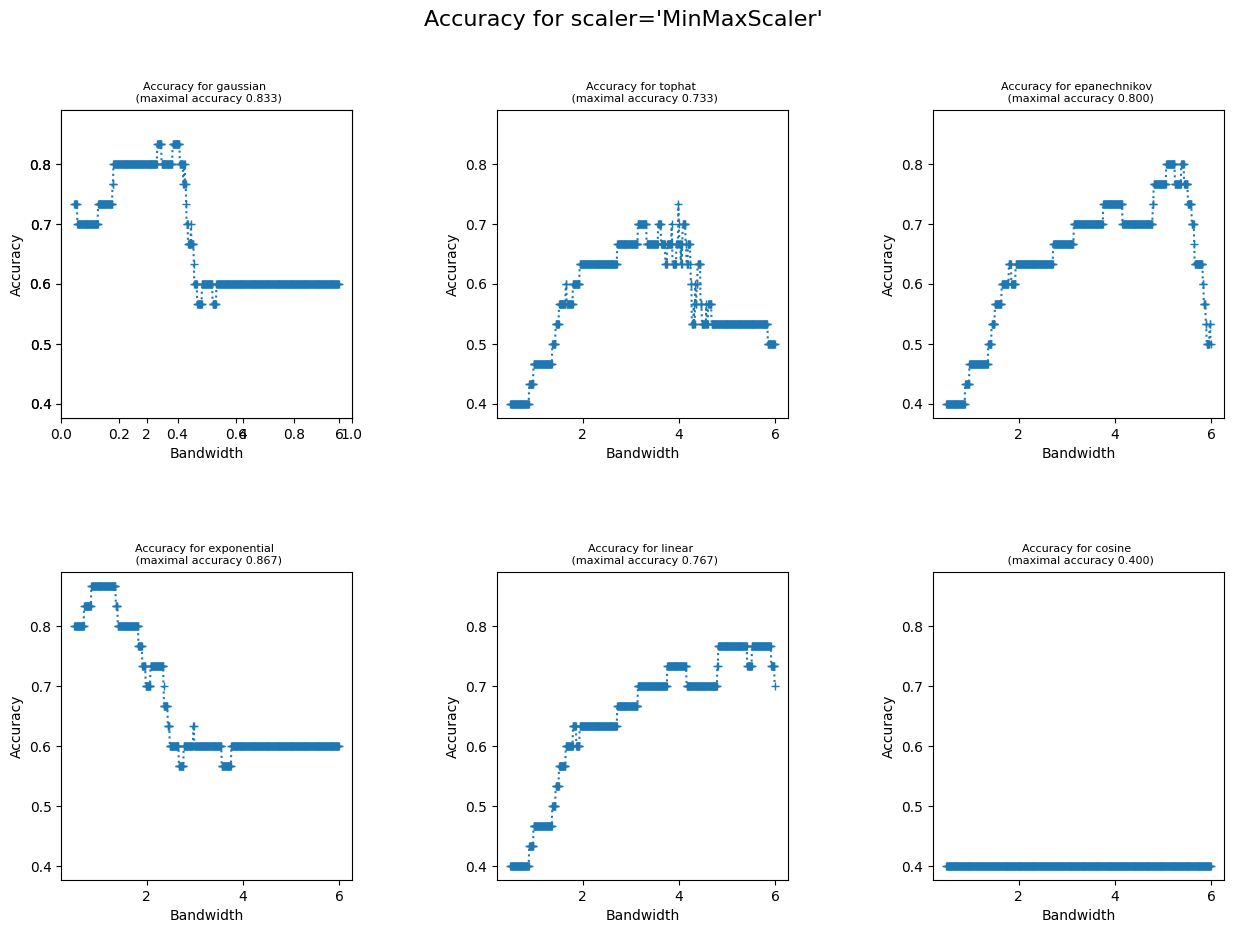

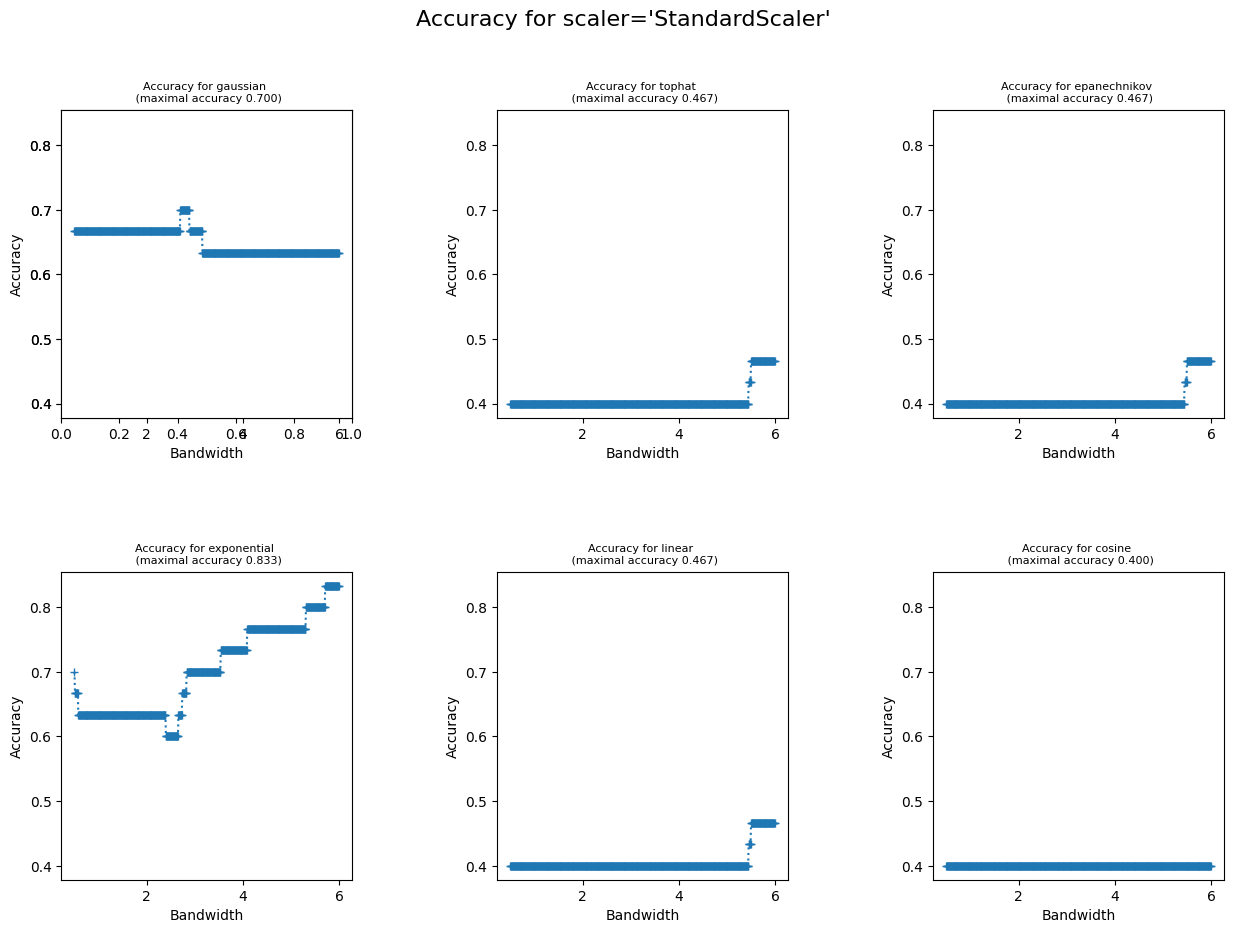

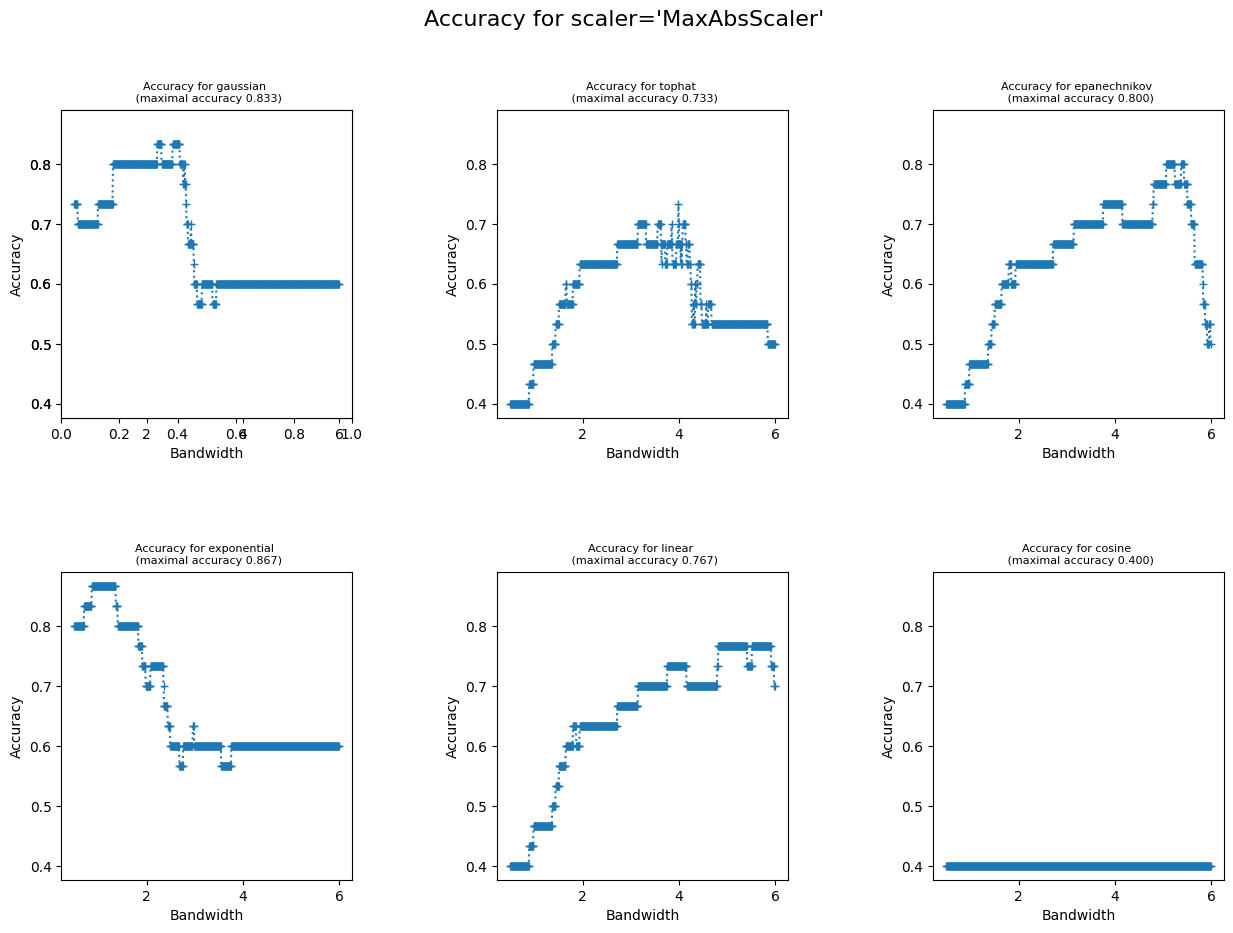

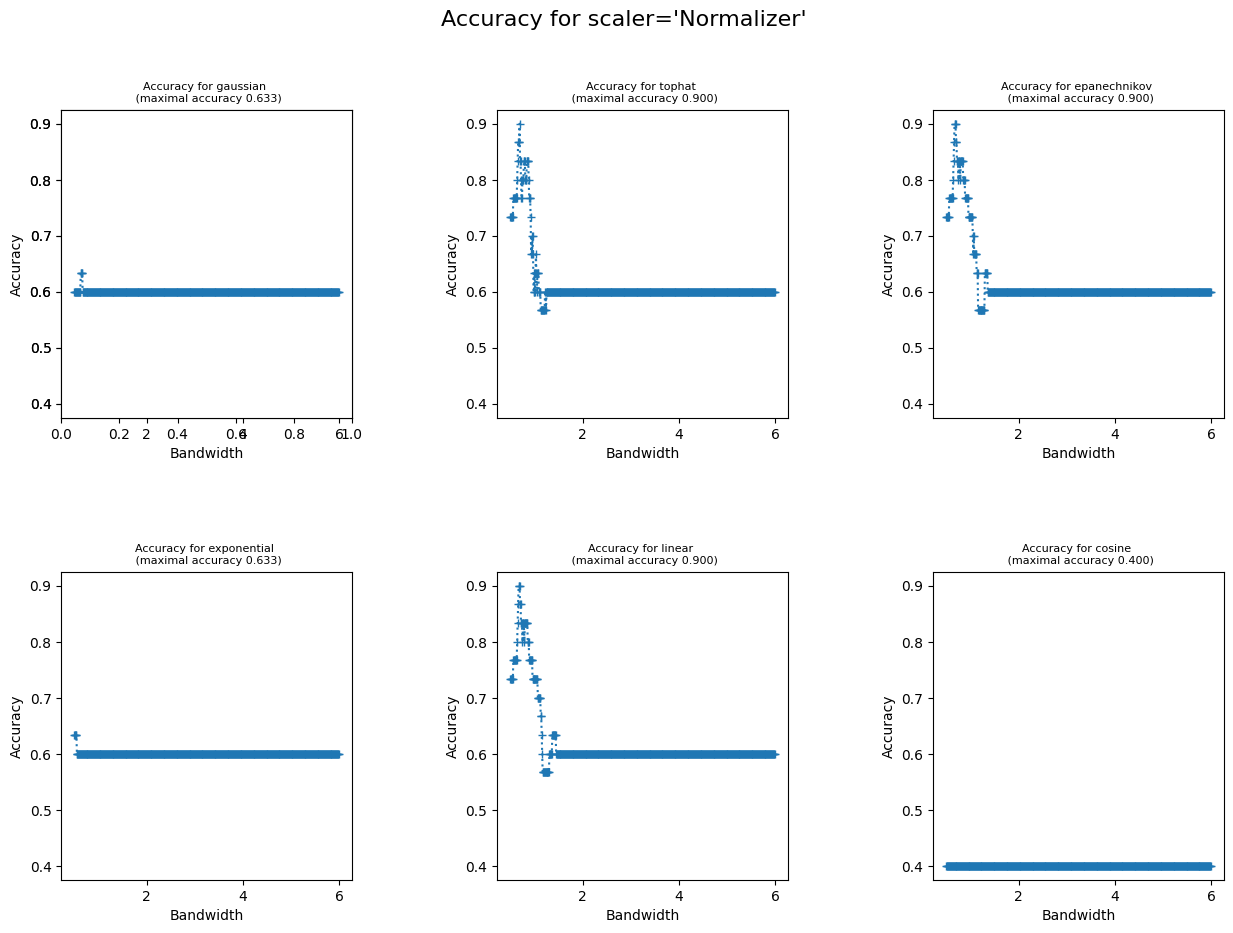

,Scaler,Kernel,Bandwidth,Accuracy
0,MinMaxScaler,exponential,0.85,0.866667
1,StandardScaler,exponential,5.71,0.833333
2,MaxAbsScaler,exponential,0.86,0.866667
3,Normalizer,tophat,0.69,0.900000


In [116]:
scalers = [MinMaxScaler, StandardScaler, MaxAbsScaler, Normalizer]
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
bandwidths = np.arange(0.5, 6, 0.01) # the most interesting range of bandwidths is from 0.5 to 6
# YOUR CODE HERE
table_sc = optimal_scaler_kernel_bandwidth(X_train, y_train, X_test, y_test, scalers, kernels, bandwidths)  
table_sc

In [128]:
best_scaler = table_sc['Scaler'][table_sc['Accuracy'].argmax()]
best_kernel = table_sc['Kernel'][table_sc['Accuracy'].argmax()]
best_bandwidth = table_sc['Bandwidth'][table_sc['Accuracy'].argmax()]
best_accuracy = table_sc['Accuracy'][table_sc['Accuracy'].argmax()]
print(f"The best accuracy {best_accuracy} was achieved with scaler {best_scaler} kernel {best_kernel} and bandwidth {best_bandwidth}")

print(f'Actually, best accuracy 0.933 was achieved with log(x+0.1) transformation, gaussian kernel and bandwidth 33.884415613914385')


The best accuracy 0.9 was achieved with scaler Normalizer kernel tophat and bandwidth 0.6900000000000002
Actually, best accuracy 0.933 was achieved with log(x+0.1) transformation, gaussian kernel and bandwidth 33.884415613914385


## 5. Visualize your best classifier

Using the first two principal components of the dataset, plot the dataset.
According to the results of your best classifier, use different colors or marks to distinguish
   * training positive samples,
   * training negative samples,
   * true positive test samples,
   * false positive test samples,
   * true negative test samples, and
   * false negative test samples.

First, compute the first two principal components for all available data, and then plot the 2D representation of the results obtained by your best classifier.

C:\Users\nelia\AppData\Local\Temp\ipykernel_3616\4243944381.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_pca[tp_idx, 0], X_pca[tp_idx, 1], c='cyan', label='True Positive (TP)', marker='1', edgecolor='k')
C:\Users\nelia\AppData\Local\Temp\ipykernel_3616\4243944381.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_pca[tn_idx, 0], X_pca[tn_idx, 1], c='magenta', label='True Negative (TN)', marker='1', edgecolor='k')


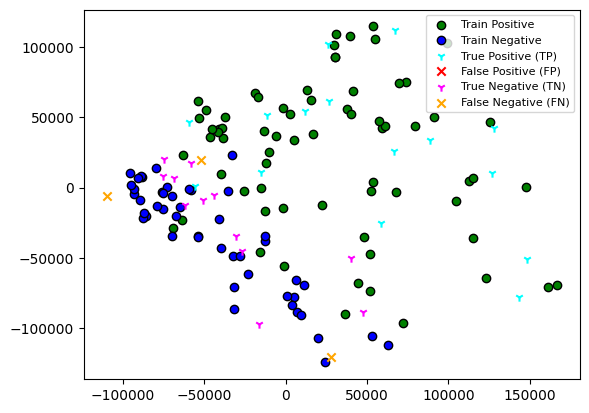

In [152]:
# YOUR CODE HERE
# find first two principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pipe = Pipeline([
    ('scaler', Normalizer()),
    ('kde', KDEBayes(kernel=best_kernel, bandwidth=best_bandwidth))
    ])

y_pred = pipe.fit(X_train, y_train).predict(X_test)

tn_idx = X_test.index[np.where((y_test == 0) & (y_pred == 0))[0]]
fp_idx = X_test.index[np.where((y_test == 0) & (y_pred == 1))[0]]
fn_idx = X_test.index[np.where((y_test == 1) & (y_pred == 0))[0]]
tp_idx = X_test.index[np.where((y_test == 1) & (y_pred == 1))[0]]

pos_idx = X_train.index[np.where(y_train == 1)[0]]
neg_idx = X_train.index[np.where(y_train == 0)[0]]

plt.scatter(X_pca[pos_idx, 0], X_pca[pos_idx, 1], c='green', label='Train Positive', marker='o', edgecolor='k')
plt.scatter(X_pca[neg_idx, 0], X_pca[neg_idx, 1], c='blue', label='Train Negative', marker='o', edgecolor='k')
plt.scatter(X_pca[tp_idx, 0], X_pca[tp_idx, 1], c='cyan', label='True Positive (TP)', marker='1', edgecolor='k')
plt.scatter(X_pca[fp_idx, 0], X_pca[fp_idx, 1], c='red', label='False Positive (FP)', marker='x')
plt.scatter(X_pca[tn_idx, 0], X_pca[tn_idx, 1], c='magenta', label='True Negative (TN)', marker='1', edgecolor='k')
plt.scatter(X_pca[fn_idx, 0], X_pca[fn_idx, 1], c='orange', label='False Negative (FN)', marker='x')
plt.legend(loc='upper right', fontsize=8)
plt.show()


Based on the visualization obtained, explain the classifier's errors (**1 point for the answer and the above plot**).

Most false negatives lie on the boundary between positive and negative or near negatives. The model performs not so well near the boundary and is not able to always separate correctly. 